Во второй части строятся модели нейросети - простая полносвязная с двумя скрытыми слоями, созданная вручную, и 3 конволюционные модели разной сложности с помощью компиляции готовых слоев keras.

In [1]:
import tensorflow as tf
import pandas as pd
from google.colab import drive
drive.mount('/gdrive' )

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

tf.compat.v1.disable_eager_execution()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
df_train = pd.read_csv('/fashion-mnist_train.csv')

X_train = df_train.iloc[:,1:].values
y_train = df_train.iloc[:,0].values

X_train = scaler.fit_transform(X_train)
y_train = tf.keras.utils.to_categorical(y_train, 10)

In [3]:
df_test = pd.read_csv('/gdrive/My Drive/fashion-mnist_test.csv')

X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values

X_test = scaler.transform(X_test)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [4]:
learning_rate = 0.1
epochs = 1000
batch_size = 32

n_hidden_1 = 256
n_hidden_2 = 256
num_input = 784
num_classes = 10

X = tf.compat.v1.placeholder('float', [None, num_input])
Y = tf.compat.v1.placeholder('float', [None, num_classes])

In [5]:
weights = {
    'h1': tf.Variable(tf.random.normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'output': tf.Variable(tf.random.normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'output': tf.Variable(tf.random.normal([num_classes]))
}


In [6]:
def network(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    output_layer = tf.matmul(layer_2, weights['output']) + biases['output']

    return output_layer

In [10]:
logits = network(X)

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y
    )
)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.compat.v1.global_variables_initializer()

In [11]:
train_scores = []
test_scores = []

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        for i in range(0,len(X_train),batch_size):
            sess.run(train, feed_dict={X: X_train[i:i+batch_size],
                                       Y: y_train[i:i+batch_size]})

        if epoch % 50 == 0 or epoch == (epochs - 1):
            train_accuracy = sess.run(accuracy, feed_dict={
                                                           X: X_train,
                                                           Y: y_train
                                                          }
                                     )

            test_accuracy = sess.run(accuracy, feed_dict={
                                                          X: X_test,
                                                          Y: y_test
                                                         }
                                    )
            train_scores.append((epoch, train_accuracy))
            test_scores.append((epoch, test_accuracy))
            


Подсчет метрики accuracy по мере обучения простой полносвязной модели с двумя скрытыми слоями. Итоговый результат на тестовых данных - 0,79.

In [12]:
train_scores

[(0, 0.73873335),
 (50, 0.80938333),
 (100, 0.8092667),
 (150, 0.7829667),
 (200, 0.7999),
 (250, 0.80265),
 (300, 0.80113333),
 (350, 0.76393336),
 (400, 0.80551666),
 (450, 0.8116),
 (500, 0.8071333),
 (550, 0.79205),
 (600, 0.7916833),
 (650, 0.80156666),
 (700, 0.7704167),
 (750, 0.7939),
 (800, 0.76945),
 (850, 0.8113833),
 (900, 0.78728336),
 (950, 0.79925),
 (999, 0.80755)]

In [13]:
test_scores

[(0, 0.7366),
 (50, 0.7956),
 (100, 0.7961),
 (150, 0.7718),
 (200, 0.7783),
 (250, 0.7882),
 (300, 0.7843),
 (350, 0.7484),
 (400, 0.7868),
 (450, 0.7976),
 (500, 0.7892),
 (550, 0.772),
 (600, 0.7761),
 (650, 0.7868),
 (700, 0.7501),
 (750, 0.7758),
 (800, 0.7465),
 (850, 0.7905),
 (900, 0.761),
 (950, 0.7775),
 (999, 0.7877)]

Далее построение конволюционных моделей с "готовыми" слоями. В целях предотвращения 'data leakage' тренировочная выборка будет дополнительно разделена для целей обучения на тренировочную и тестовую подвыборки, а датасет fashion-mnist_test.csv будет использован в качестве валидационной для подсчета итоговой метрики accuracy. Также в целях снижения времени обучения количество эпох будет снижено до 100.

In [16]:
from sklearn.model_selection import train_test_split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_train, y_train)
Xc_train = Xc_train.reshape(len(Xc_train), 28, 28, 1)
Xc_test = Xc_test.reshape(len(Xc_test), 28, 28, 1)
X_test_eval = X_test.reshape(len(X_test), 28, 28, 1)

epochs = 100

Первая модель с небольшим количеством слоев, итоговый показатель accuracy - 0,81.

In [17]:
model_1 = tf.keras.models.Sequential()

model_1.add(tf.keras.layers.Convolution2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model_1.add(tf.keras.layers.MaxPooling2D((2,2)))
model_1.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
model_1.add(tf.keras.layers.MaxPooling2D((2,2)))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_1.compile(
                  loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy']
                  )

_ = model_1.fit(
    Xc_train, yc_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(Xc_test, yc_test)
)

Train on 45000 samples, validate on 15000 samples
Epoch 1/100
44992/45000 [============================>.] - ETA: 0s - loss: 2.2345 - accuracy: 0.1871

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


45000/45000 [==============================] - 31s 690us/sample - loss: 2.2345 - accuracy: 0.1872 - val_loss: 2.1516 - val_accuracy: 0.3263
Epoch 2/100
45000/45000 [==============================] - 31s 686us/sample - loss: 2.0711 - accuracy: 0.4228 - val_loss: 1.9852 - val_accuracy: 0.4737
Epoch 3/100
45000/45000 [==============================] - 31s 691us/sample - loss: 1.8986 - accuracy: 0.4946 - val_loss: 1.8077 - val_accuracy: 0.5197
Epoch 4/100
45000/45000 [==============================] - 34s 751us/sample - loss: 1.7186 - accuracy: 0.5518 - val_loss: 1.6268 - val_accuracy: 0.5833
Epoch 5/100
45000/45000 [==============================] - 31s 691us/sample - loss: 1.5416 - accuracy: 0.6044 - val_loss: 1.4573 - val_accuracy: 0.6179
Epoch 6/100
45000/45000 [==============================] - 31s 686us/sample - loss: 1.3833 - accuracy: 0.6333 - val_loss: 1.3127 - val_accuracy: 0.6429
Epoch 7/100
45000/45000 [==============================] - 31s 679us/sample - loss: 1.2538 - accurac

In [18]:
loss_1, accuracy_1 = model_1.evaluate(X_test_eval, y_test, verbose=0)
loss_1, accuracy_1

(0.5310625603199005, 0.8091)

Вторая модель с увеличенным количеством слоев, итоговый показатель улучшился - 0,84.

In [19]:
model_2 = tf.keras.models.Sequential()

model_2.add(tf.keras.layers.Convolution2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model_2.add(tf.keras.layers.MaxPooling2D((2,2)))
model_2.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D((2,2)))
model_2.add(tf.keras.layers.Convolution2D(128, (3,3), activation='relu'))
model_2.add(tf.keras.layers.Convolution2D(256, (3,3), activation='relu'))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(512, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(512, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(10, activation='softmax'))

model_2.compile(
                  loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy']
                  )

_ = model_2.fit(
    Xc_train, yc_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(Xc_test, yc_test)
)

Train on 45000 samples, validate on 15000 samples
Epoch 1/100
45000/45000 [==============================] - ETA: 0s - loss: 2.2891 - accuracy: 0.2013

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


45000/45000 [==============================] - 69s 2ms/sample - loss: 2.2891 - accuracy: 0.2013 - val_loss: 2.2691 - val_accuracy: 0.3423
Epoch 2/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 2.2402 - accuracy: 0.3740 - val_loss: 2.1921 - val_accuracy: 0.4795
Epoch 3/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 2.1165 - accuracy: 0.4440 - val_loss: 1.9835 - val_accuracy: 0.5167
Epoch 4/100
45000/45000 [==============================] - 70s 2ms/sample - loss: 1.8339 - accuracy: 0.4900 - val_loss: 1.5960 - val_accuracy: 0.5545
Epoch 5/100
45000/45000 [==============================] - 71s 2ms/sample - loss: 1.4787 - accuracy: 0.5350 - val_loss: 1.2611 - val_accuracy: 0.6081
Epoch 6/100
45000/45000 [==============================] - 70s 2ms/sample - loss: 1.2420 - accuracy: 0.5719 - val_loss: 1.0823 - val_accuracy: 0.6398
Epoch 7/100
45000/45000 [==============================] - 70s 2ms/sample - loss: 1.1117 - accuracy: 0.6026 - va

In [20]:
loss_2, accuracy_2 = model_2.evaluate(X_test_eval, y_test, verbose=0)
loss_2, accuracy_2

(0.44316959528923033, 0.8391)

Третья модель с добавлением к предыдущей слоев BatchNormalization. Итоговый результат получился наилучшим из всех построенных моделей - 0,87.

In [21]:
model_3 = tf.keras.models.Sequential()

model_3.add(tf.keras.layers.Convolution2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model_3.add(tf.keras.layers.MaxPooling2D((2,2)))
model_3.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
model_3.add(tf.keras.layers.MaxPooling2D((2,2)))
model_3.add(tf.keras.layers.Convolution2D(128, (3,3), activation='relu'))
model_3.add(tf.keras.layers.Convolution2D(256, (3,3), activation='relu'))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(512, activation='relu'))
model_3.add(tf.keras.layers.Dropout(0.2))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Dense(512, activation='relu'))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.Dropout(0.2))
model_3.add(tf.keras.layers.Dense(10, activation='softmax'))

model_3.compile(
                  loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy']
                  )

_ = model_3.fit(
    Xc_train, yc_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(Xc_test, yc_test)
)

Instructions for updating:
Colocations handled automatically by placer.
Train on 45000 samples, validate on 15000 samples
Epoch 1/100
44992/45000 [============================>.] - ETA: 0s - loss: 2.2276 - accuracy: 0.3133

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


45000/45000 [==============================] - 69s 2ms/sample - loss: 2.2273 - accuracy: 0.3134 - val_loss: 1.2410 - val_accuracy: 0.5960
Epoch 2/100
45000/45000 [==============================] - 70s 2ms/sample - loss: 1.3789 - accuracy: 0.5576 - val_loss: 0.9400 - val_accuracy: 0.6864
Epoch 3/100
45000/45000 [==============================] - 70s 2ms/sample - loss: 1.1319 - accuracy: 0.6323 - val_loss: 0.8245 - val_accuracy: 0.7179
Epoch 4/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 1.0244 - accuracy: 0.6650 - val_loss: 0.7536 - val_accuracy: 0.7366
Epoch 5/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 0.9512 - accuracy: 0.6822 - val_loss: 0.7082 - val_accuracy: 0.7477
Epoch 6/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 0.9029 - accuracy: 0.6968 - val_loss: 0.6731 - val_accuracy: 0.7605
Epoch 7/100
45000/45000 [==============================] - 69s 2ms/sample - loss: 0.8542 - accuracy: 0.7106 - va

In [22]:
loss_3, accuracy_3 = model_3.evaluate(X_test_eval, y_test, verbose=0)
loss_3, accuracy_3

(0.3516203526854515, 0.8732)

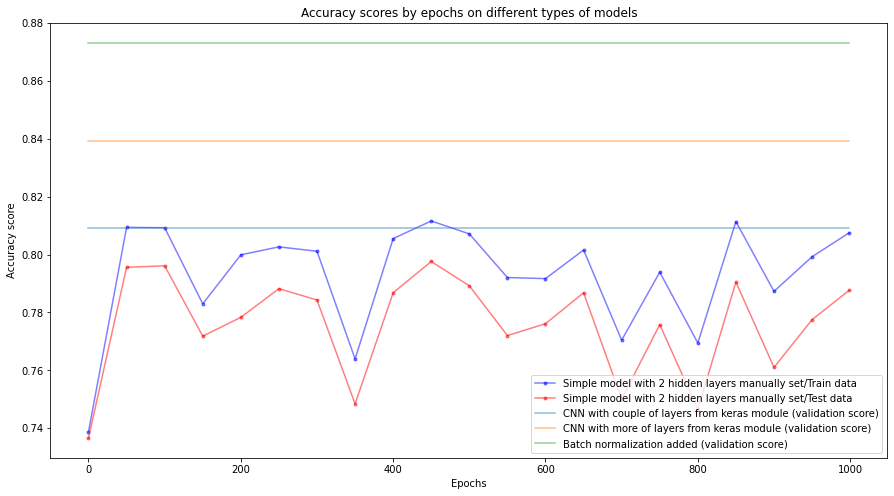

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
plt.plot([i[0] for i in train_scores], [i[1] for i in train_scores],
         '-o', c='blue', label='Simple model with 2 hidden layers manually set/Train data',
         alpha=0.5, markersize=3)

plt.plot([i[0] for i in test_scores], [i[1] for i in test_scores],
         '-o', c='red', label='Simple model with 2 hidden layers manually set/Test data',
         alpha=0.5, markersize=3)

plt.plot(list(range(1000)), [accuracy_1 for i in range(1000)],
         alpha=0.5, label='CNN with couple of layers from keras module (validation score)')

plt.plot(list(range(1000)), [accuracy_2 for i in range(1000)],
         alpha=0.5, label='CNN with more of layers from keras module (validation score)')

plt.plot(list(range(1000)), [accuracy_3 for i in range(1000)],
         alpha=0.5, label='Batch normalization added (validation score)')

plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.title('Accuracy scores by epochs on different types of models')
plt.legend();

График изменения показателя accuracy на тренировочной и тестовой выборках по мере обучения простой модели, созданной вручную. Линиями указаны итоговые валидационные показатели трех более сложных конволюционных моделей с использованием "готовых" слоев keras. Итоговые показатели метрики accuracy от наилучшей модели к худшей:
1) 0,87 - конв. модель с использованием слоев BatchNormalization

2) 0,84 - конв. модель с увеличенным количеством слоев

3) 0,81 - конв. модель с небольшим количеством слоев

4) 0,79 - простая полносвязная модель с двумя скрытыми слоями.

Из первой части (модели лог. регр.) построенная вручную модель как нейросеть без скрытых слоев показала наихудшие результаты из всех 6 моделей - 0,77. "Коробочное решение" библиотеки sklearn с подбором оптимальных параметров через GridSearchCV разместилось на втором месте с показателем 0,86.